# Preprocesamiento paso a paso


Realizaremos el preprocesamiento en este *notebook* para todo el conjunto de datos como una hipótesis inicial para entender mejor los datos y determinar qué transformaciones son necesarias. Sin embargo, **después se definirá correctamente el *pipeline* y se entrenará únicamente con el conjunto de entrenamiento para garantizar la validez del modelo**.

Esto nos permite:

- Entender los datos: identificar valores faltantes, outliers, distribuciones, y posibles transformaciones necesarias.
- Definir hipótesis: probar diferentes estrategias de preprocesamiento (imputación, escalado, codificación, etc.) para ver cuáles funcionan mejor.
- Planificar el pipeline: determinar qué pasos de preprocesamiento son necesarios y cómo implementarlos.

Sin embargo, **es crucial recordar que esta fase es solo exploratoria**. Una vez identificados los pasos necesarios, debemos encapsularlos en un *pipeline* que se aplique después de dividir los datos en conjuntos de entrenamiento y prueba. Esto garantiza que:

- El conjunto de prueba permanezca intacto: no se utiliza para tomar decisiones durante el entrenamiento, lo que evita la fuga de datos (data leakage).
- El pipeline sea robusto: aprende los parámetros de preprocesamiento (por ejemplo, la media para imputación o los factores de escalado) solo del conjunto de entrenamiento, lo que simula mejor el comportamiento en producción.

## Carga y preparación de datos

In [1]:
import pandas as pd
df = pd.read_csv('../data/life_expectancy.csv')

Antes de nada, eliminaremos las filas con valores no disponibles en la columna target, ya que no nos servirán para entrenar un modelo de aprendizaje supervisado ni para evaluarlo.
<!-- TODO: Guardarlos para imputaciones? -->

In [2]:
df.dropna(subset=['LifeExpectancy'], inplace=True)

También eliminaremos las columnas 'Country', 'Year' y 'Status' porque no las hemos considerado parte de la definición del problema.

In [3]:
df.drop(columns=['Country', 'Year', 'Status'], inplace=True)

## *Feature Engineering*

Unificamos las columnas 'thinness1-19' y 'thinness5-9' en una sola columna 'thinness' con la media de ambas.

Usamos el método `mean` de pandas, que por defecto ignora los valores nan al calcular la media (parámetro `skipna=True`). Esto evita invalidar filas completas cuando solo falta un dato, igual que np.nanmean. 
Para replicar el comportamiento de np.mean (que devuelve nan si hay algún valor faltante), habría que modificar el parámetro `skipna=False`. 
Es importante destacar que numpy tiene np.nanmean específicamente para el caso donde queremos ignorar nans, mientras que en pandas esta lógica está integrada en el parámetro skipna.
Aunque en nuestros datos actuales no hay valores faltantes en estas columnas, esta implementación hace el *pipeline* más **robusto** ante posibles valores nan futuros, ya que el cálculo se adaptaría automáticamente sin necesidad de cambios.

In [4]:
import numpy as np
df['thinness'] = df[['thinness1-19', 'thinness5-9']].mean(axis=1)

In [5]:
df[['thinness', 'thinness1-19', 'thinness5-9']].isnull().sum()

thinness        32
thinness1-19    32
thinness5-9     32
dtype: int64

Observamos que no hemos solucionado los valores faltantes en 'thinness', es el mismo número de nan que teníamos en cada una de sus columnas originales, así que la media ignorando nan no nos ha solucionado el problema en este caso. Sin embargo, sigue siendo una solución más robusta y puede ser útil en futuros datos donde solo falte un valor.

En cualquier caso, eliminamos las columnas previas 'thinness1-19' y 'thinness5-9' porque ya no las necesitamos.

In [6]:
df.drop(columns=['thinness1-19', 'thinness5-9'], inplace=True)

Vemos que 'underfiveDeaths' e 'InfantDeaths' son métricas parecidas y con correlación de 1 entre ellas. Optaremos por mantener solo la que más correla con 'LifeExpectancy' de las dos (aunque la diferencia sea pequeña).

In [7]:
df.drop(columns=['InfantDeaths'], inplace=True)

## Valores no disponibles

Comprobamos la cantidad de valores nan en el dataset.

In [8]:
def get_nan_per_column(df, show_all=False):
    na_per_colum = df.isna().sum()
    na = pd.DataFrame({
        'NaN': na_per_colum,
        'Perc': (na_per_colum / df.shape[0] * 100).round(1)
    })
    if show_all:
        return na.sort_values(by='Perc', ascending=False)
    else:
        return na[na['NaN'] > 0].sort_values(by='Perc', ascending=False)

get_nan_per_column(df)

,NaN,Perc
Population,644,22.0
HepatitisB,553,18.9
GDP,443,15.1
Total expenditure,226,7.7
Alcohol,193,6.6
Income,160,5.5
Schooling,160,5.5
BMI,32,1.1
thinness,32,1.1
Polio,19,0.6


La columna 'Population' es la que más valores no disponibles tiene y la que guarda menos correlación con la variable objetivo. Por lo que la eliminamos. 'HepatitisB' y 'GDP' también tienen bastantes valores no disponibles, pero tienen algo más de correlación y la decisión puede ser más difícil de tomar. Eliminaremos 'HepatitisB' y dejaremos 'GDP' para ver cómo se comporta en los distintos métodos de tratamiento de valores faltantes ya que sí parece una variable relevante.

In [9]:
# drop rows with too many NaN values and low correlation with target
df.drop(columns=['Population', 'HepatitisB'], inplace=True)

# drop rows with odd values and low correlation with target
df.drop(columns=['Measles'], inplace=True)  

In [10]:
get_nan_per_column(df)

,NaN,Perc
GDP,443,15.1
Total expenditure,226,7.7
Alcohol,193,6.6
Income,160,5.5
Schooling,160,5.5
BMI,32,1.1
thinness,32,1.1
Polio,19,0.6
Diphtheria,19,0.6


Para aquellas columnas con poco porcentaje de valores faltantes, podemos imputar con la media o la mediana. Para aquellas con un porcentaje mayor, podemos usar un modelo de imputación más avanzado como KNN.

Además, hemos visto que 'Income' tiene valores nan y también muchos valores 0 que no tienen sentido. Aunque parece que los valores nan y los 0 lo son por motivos distintos, al imputarlos con KNN Imputer no tenemos que tratarlos distinto. 

In [11]:
df['Income'] = df['Income'].replace(0, np.nan)


median_impute_features = ['BMI', 'thinness', 'Polio', 'Diphtheria']
knn_impute_features = ['GDP', 'Total expenditure', 'Alcohol', 'Income', 'Schooling']

Normalmente, se escala el conjunto de datos antes de imputar valores faltantes para evitar que los valores faltantes afecten a la media y la varianza. Haremos esto con las columnas en que imputamos la mediana.

In [12]:
from sklearn.impute import SimpleImputer
df[median_impute_features] = SimpleImputer(strategy='median').fit_transform(df[median_impute_features])


Para usar KNN, debemos escalar los datos primero. Usaremos `StandardScaler` para que todas las variables tengan media 0 y desviación estándar 1. Esto es importante para que todas las variables tengan el mismo peso en el cálculo de distancias.

Además, KNN es también sensible a las distribución de las variables, por lo que aplicaremos una transformación logarítmica a aquellas que son muy asimétricas. La regresión lineal (que será uno de los modelos que usemos) también se beneficia de esta transformación.

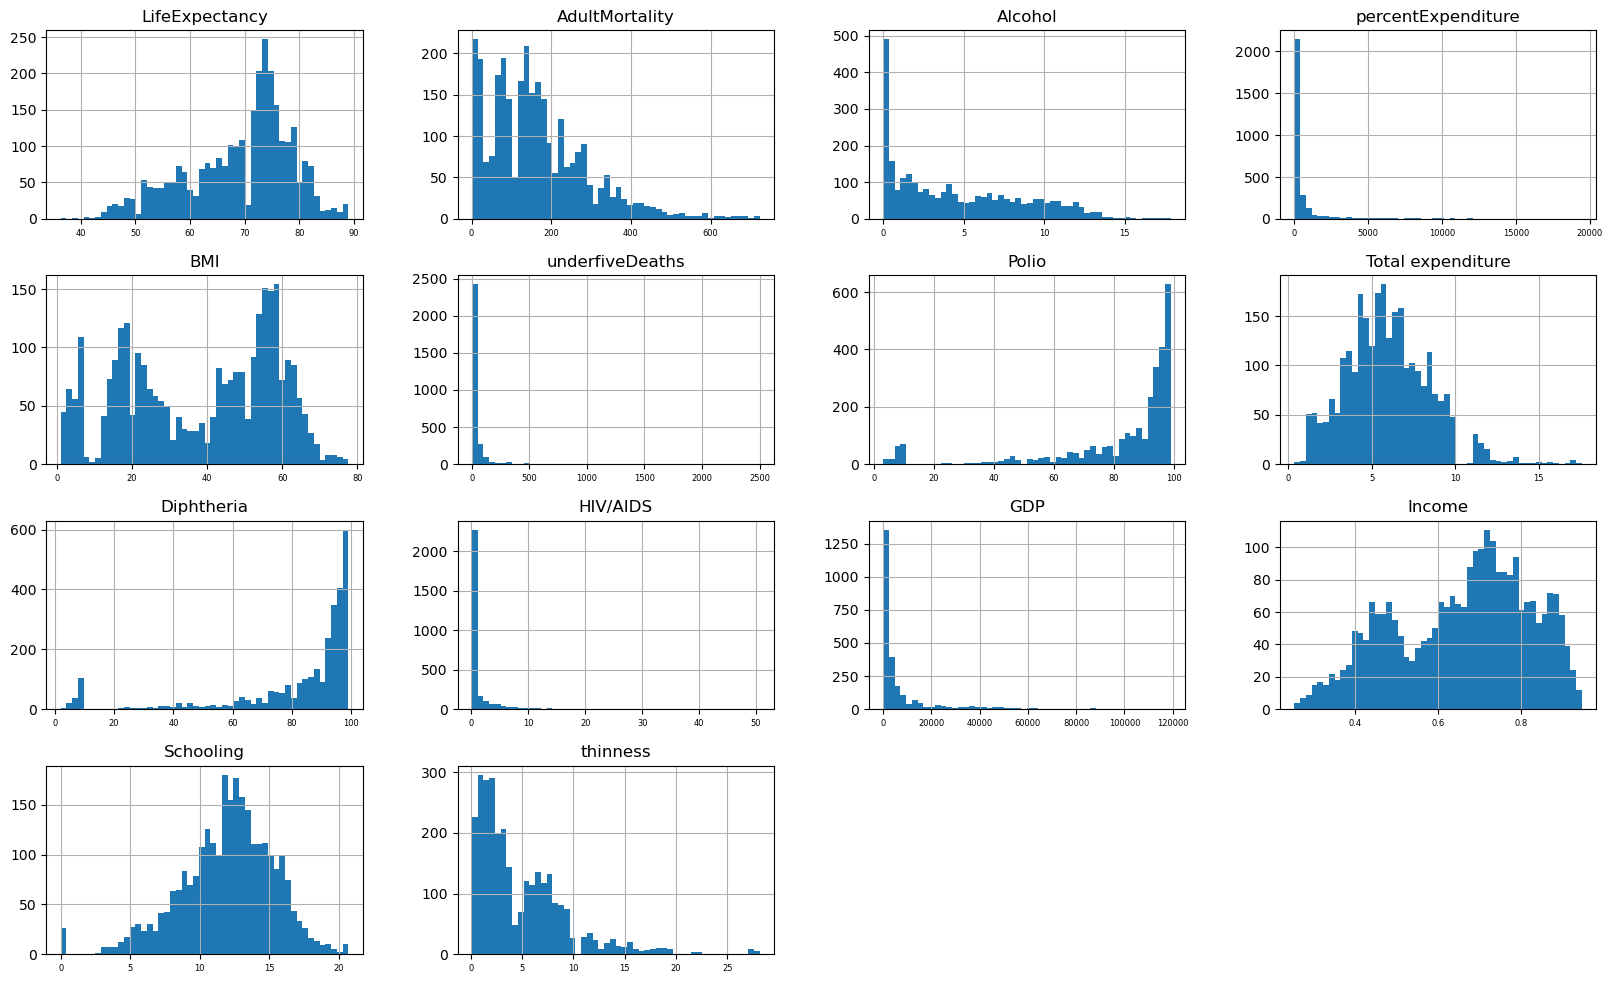

In [13]:
_ = df.hist(bins=50, figsize=(20, 12), xlabelsize=6) 

In [14]:
# Log transform skewed features
skewed_features = ['underfiveDeaths', 'Alcohol', 'percentExpenditure', 'Polio', 'Diphtheria', 'HIV/AIDS', 'GDP']
df[skewed_features] = np.log1p(df[skewed_features])

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas")
df = scaler.fit_transform(df)

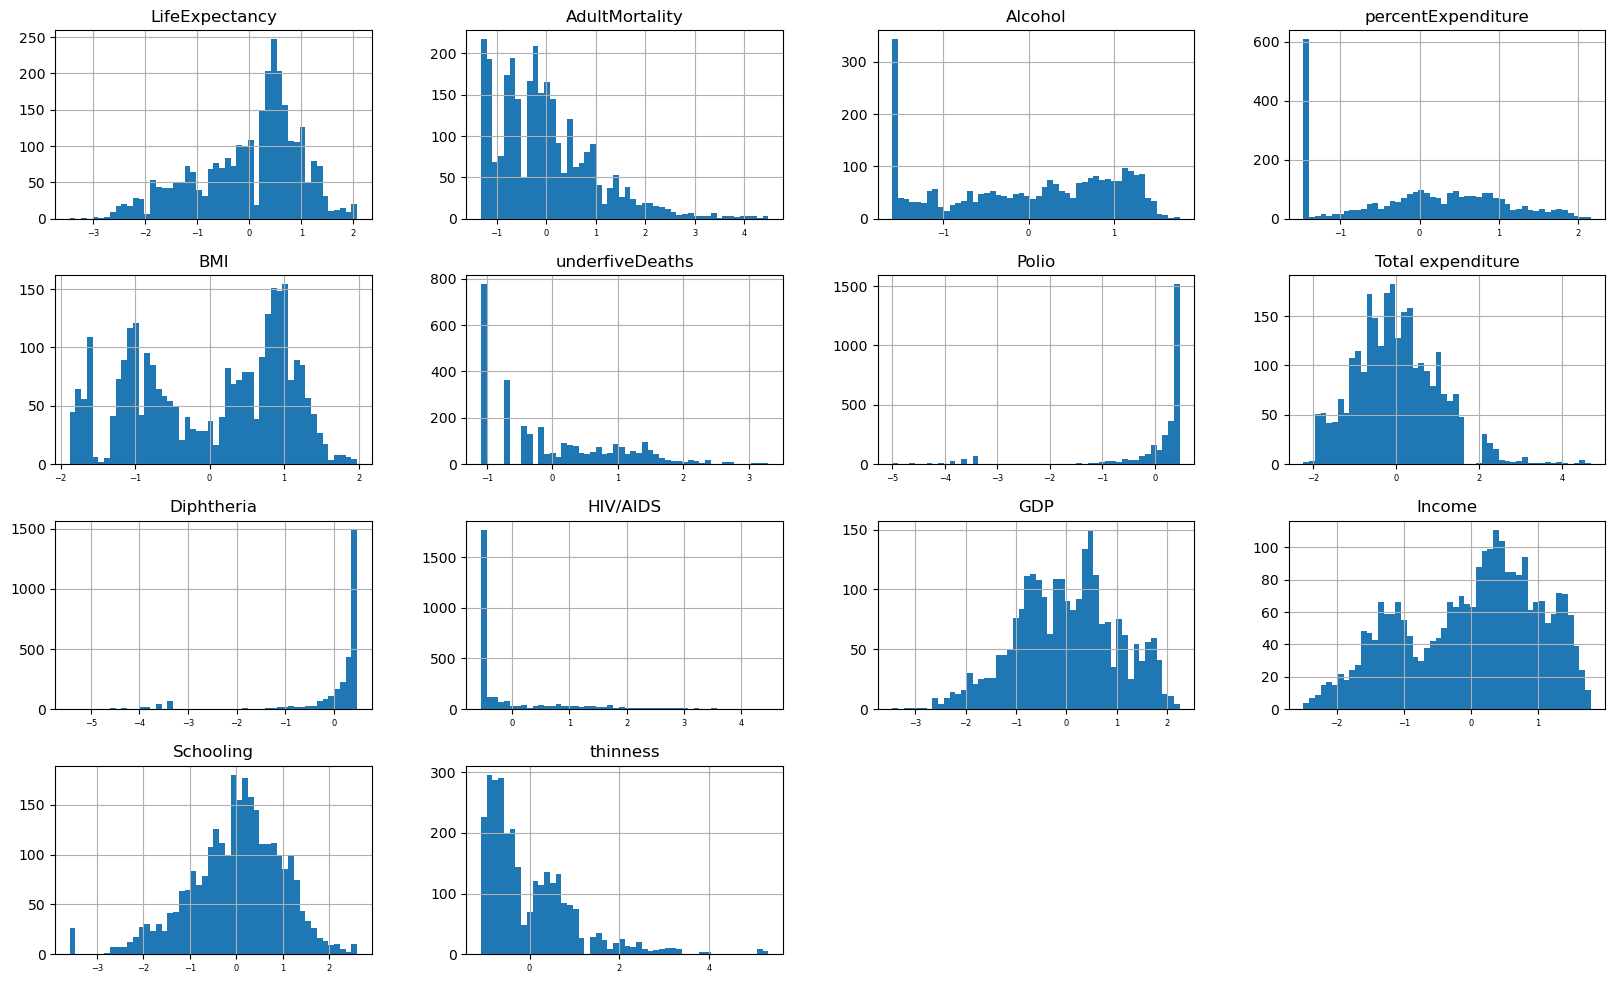

In [15]:
_ = df.hist(bins=50, figsize=(20, 12), xlabelsize=6) 

Un heurístico típico para calcular el número de vecinos en KNNImputer es la raíz cuadrada del número de muestras.

In [16]:
n_neighbors = np.sqrt(df.shape[0]).astype(int)

from sklearn.impute import KNNImputer
df[knn_impute_features] = KNNImputer(n_neighbors=n_neighbors).fit_transform(df[knn_impute_features])

Con esto hemos conseguido un conjunto de datos limpio y listo para ser usado en un modelo de aprendizaje supervisado.

In [17]:
get_nan_per_column(df)

,NaN,Perc


Siguen quedando pendientes los valores a cero de 'Income', que sabemos que no parecen tener la misma causa que los valores nan y que no pueden ser tratados con la media o la mediana. Podríamos probar a imputarlos con KNNImputer. Si optamos por convertirlos a nan, podemos hacerlo así:

In [18]:
df['Income'] = df['Income'].replace(0, np.nan)